In [34]:
import pandas as pd
import numpy as np
   
tourney_df = pd.read_csv("data/data.csv", index_col=0)
tourney_df.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,std_stl0,std_stl1,avg_blk0,avg_blk1,std_blk0,std_blk1,avg_pf0,avg_pf1,std_pf0,std_pf1
0,2003,134,1421,92,1411,84,N,1,32,69,...,2.31,3.14,2.23,3.00,1.72,1.65,18.30,19.10,4.56,3.69
1,2003,136,1112,80,1436,51,N,0,31,66,...,3.65,3.50,4.21,2.97,2.01,1.72,17.75,15.90,2.99,4.05
2,2003,136,1113,84,1272,71,N,0,31,59,...,2.14,3.16,4.24,5.07,2.94,3.16,19.41,18.76,3.25,4.34
3,2003,136,1141,79,1166,73,N,0,29,53,...,2.82,2.94,4.45,4.00,2.22,2.35,17.27,20.97,3.12,4.81
4,2003,136,1143,76,1301,74,N,1,27,64,...,2.64,3.63,2.79,3.07,1.63,2.49,17.10,18.67,3.74,4.21


# Choosing Features to Use for Model

Edit featureList below to use any of the features in the data frame above (see above for names of columns).  

In [35]:
featureList = ['wins0', 'wins1']
y = tourney_df['team0Win'].values # results
X = tourney_df[featureList].values # features

In [36]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [26]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
print("Means = {0}, Stdevs = {1}".format(scaler.mean_, scaler.scale_))

Means = [ 23.83899557  24.01033973], Stdevs = [ 3.76162904  3.67130427]


/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [38]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Train our model!

In [40]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(0, 3, 4)
gamma_range = np.logspace(-3, 0, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=42)
grid = GridSearchCV(svm.SVC(probability=True, kernel='rbf'), scoring="log_loss", param_grid=param_grid, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train) 
print "The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_) 

The best parameters are {'C': 1.0, 'gamma': 0.01} with a score of -0.61


In [92]:
model = grid.best_estimator_
y_pred = model.predict_proba(X_test) # probability that team0 wins (what Kaggle calls team 1, and wants for submission)
from sklearn import metrics
print("Log loss is {0}".format(metrics.log_loss(y_test, y_pred)))

Log loss is 0.621890422427


In [93]:
def write_submission_file(model, featureList, scaler): # see submission.ipynb for details
    import pandas as pd
    sample_df = pd.read_csv('data/SampleSubmissionWithFeatures.csv', index_col=0)
    Xsample = sample_df[featureList].values
    Xsample = scaler.transform(Xsample)
    sample_df['Pred'] = model.predict_proba(Xsample)[:,1] # predict_proba returns [prob label is 0, prob label is 1], kaggle wants 2nd column
    submission = sample_df[['Id', 'Pred']]
    submission.to_csv("data/submission.csv", encoding='ascii', index=False)

In [94]:
write_submission_file(model, featureList, scaler)

/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [95]:
sample_df = pd.read_csv('data/submission.csv', index_col=0)
sample_df.head()

,Pred
Id,
2012_1104_1124,0.299787
2012_1104_1125,0.299787
2012_1104_1140,0.430548
2012_1104_1143,0.385633
2012_1104_1153,0.385633


In [ ]:
from sklearn import svm
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
C_range = np.logspace(0, 5, 6)
classifiers = []
for C in C_range:
    clf = svm.SVC(probability=True, kernel='rbf',C=C, gamma=0.01)
    clf.fit(X_train, y_train)
    classifiers.append((C, clf))


In [ ]:
# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

/Users/dtamayo/miniconda2/envs/ml2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


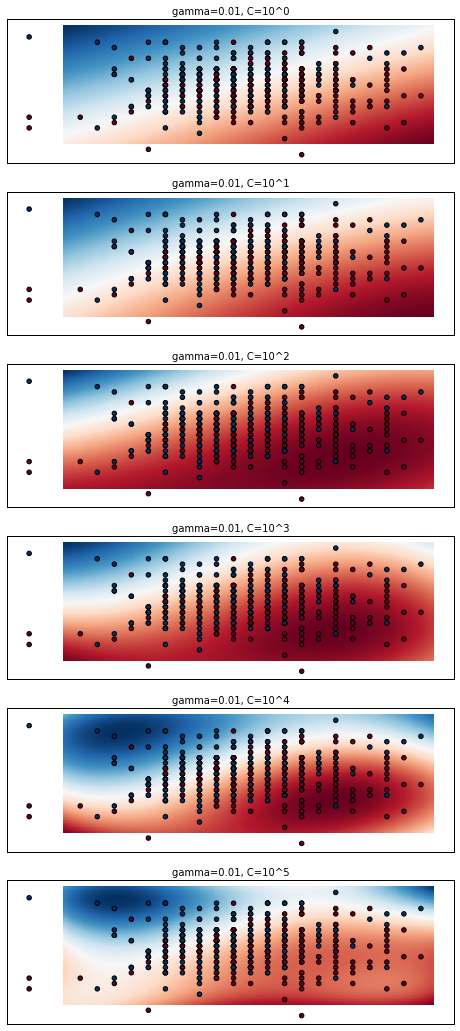

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 18))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_range), 1, k + 1)
    plt.title("gamma=0.01, C=10^%d" % (np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

In [8]:
y_pred = model.predict_proba(X_test) # probability that team0 wins (what Kaggle calls team 1, and wants for submission)
for i in range(5):
    print("Features = {0}, Pred. prob. team0 wins: {1}".format(X_test[i], y_pred[i]))

Features = [ 0.58820681  1.62624673], Pred. prob. team0 wins: [ 0.60544677  0.39455323]
Features = [ 2.5224709   0.26541786], Pred. prob. team0 wins: [ 0.36823949  0.63176051]
Features = [ 0.86453025  2.17057827], Pred. prob. team0 wins: [ 0.66750743  0.33249257]
Features = [-0.51708696 -0.00674791], Pred. prob. team0 wins: [ 0.53765851  0.46234149]
Features = [ 1.41717713  0.53758363], Pred. prob. team0 wins: [ 0.33448825  0.66551175]


# Calculating logloss 

Now the target vector is modified to be team0Win, when team0Win, y=1, which is consistant with the Koggle definition and the github definition. Please compare http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html and https://www.kaggle.com/c/march-machine-learning-mania-2016/details/evaluation to make sure we're doing the same thing.

In [9]:
from sklearn import metrics
print("Log loss is {0}".format(metrics.log_loss(y_test, y_pred)))

Log loss is 0.59157953881


# Making a submission on Kaggle

The following call generates a file `data/submission.csv` that uses the model you pass it to generate probabilities for all the matches Kaggle wants us to predict.  It will overwrite any previous file.  See `submission.ipynb` for a walk-through of the function.  Have to pass it the model you trained, and the featureList you used.

In [8]:
write_submission_file(model, featureList)

In [ ]:
def write_submission_file(_model, _featureList): # see submission.ipynb for details
    import pandas as pd
    sample = pd.read_csv('data/sample.csv', index_col=0)
    Xsample = sample[_featureList].values
    sample['Pred'] = _model.predict_proba(Xsample)[:,0]
    submission = sample[['Id', 'Pred']]
    submission.to_csv("data/submission.csv", encoding='ascii')
 